# Model Training

<br/>

<pre>
network architecture:  resnet18
dataset:               imagewoof
image size:            128x128 (resized beforehand)
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagewoof dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagewoof dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

For training the model we use a [resnet18](https://arxiv.org/abs/1512.03385) network architecture because a) the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) provides [it](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) already, and b) it does not contain too many layers. An architecture with too many layers result into many activations that we need to compute when testing our OoD detection method as we need to compute activations from layers of all parts of the network, i.e., not necessarily all layers but at least every other layer.

Our training setup is inspired by [this](https://github.com/fastai/fastai2/blob/master/nbs/22_tutorial.imagenette.ipynb) and [this](https://jovian.ai/upen-178/imagenette-classification) sample training setup. 

<br/>

_Sources:_
* [Imagewoof dataset](https://github.com/fastai/imagenette)
* [Fastai imagenette training tutorial](https://github.com/fastai/fastai2/blob/master/nbs/22_tutorial.imagenette.ipynb)
* [PyTorch imagenette training sample setup](https://jovian.ai/upen-178/imagenette-classification)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
                                                                                                                                                                                                                                                                                                                                                                                                    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform
from pathlib import Path
import random

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.7.12
torch version:       1.11.0
torchvision version: 0.12.0
numpy version:       1.21.6
matplotlib version:  3.5.3
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla P100-PCIE-16GB

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.11/notes/randomness.html?highlight=repro). Additionally, we could set the environment variable __CUBLAS_WORKSPACE_CONFIG__ because otherwise __torch.use_deterministic_algorithms(True)__ would not work.

In [2]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8 

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 

## Parameters

In [4]:
# Data
img_size          = 128                                                             # Image size
num_classes       = 10                                                              # Number of classes
base_data_folder  = Path('/kaggle/input')                                           # Base data folder
fname_string      = 'imagewoof-{}'.format(img_size)                                 # Dataset folder name
dataset_path      = base_data_folder/fname_string                                   # Dataset path
batch_size_train  = 64                                                              # Batch size training set
batch_size_test   = 1000                                                            # Batch size test set
calibset_size     = 750                                                             # Size of the calibration set

# Training
base_out_folder   = Path('/kaggle/working')                                         # Base output folder
fname_string      = 'imagewoof_{}_resnet18'.format(img_size)                        # Model name
model_path        = base_out_folder/fname_string                                    # Model path
out_path          = base_out_folder/fname_string                                    # Output path
arch              = models.resnet18(pretrained=False)                               # Network architecture
num_epochs        = 60                                                              # Number of epochs
learning_rate     = 6e-3                                                            # Learning rate
grad_clip         = 0.1                                                             # Gradient clipping
weight_decay      = 1e-5                                                            # Weight decay
log_interval      = 10                                                              # printing training statistics after 10 iterations 

## Function for Displaying Images

In [5]:
labels = (
    'Samoyed',
    'English foxhound',
    'Old English sheepdog',
    'Rhodesian ridgeback',
    'beagle',
    'Australian terrier',
    'golden retriever',
    'dingo',
    'Shih-Tzu',
    'Border terrier'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
        img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
        img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Load Data

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128, padding=8, padding_mode='reflect'), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

For our OoD detection method we need a calibration set later. The calibration set should not be drawn from the training distribution. However, we still need their labels. Thus, we split the original test set into two sets. One is used as the calibration set and the other one is used as the new test set for evaluating the model and calculating the credibility scores using our OoD detection method later. According to [Papernot and McDaniel](https://arxiv.org/abs/1803.04765) we chose a calibration set size of 750 samples.

In [7]:
# Data paths
train_path = dataset_path/'train'
test_path = dataset_path/'val'

# Training set
trainset = datasets.ImageFolder(
    root=str(train_path), transform=transform_train
)

# Test set 
orig_testset = datasets.ImageFolder(
    root=str(test_path), transform=transform_test
)
orig_testset_size = len(orig_testset)
testset_size = orig_testset_size - calibset_size

# Calibration set 
testset, calibset = torch.utils.data.random_split(
    orig_testset, [testset_size, calibset_size], generator=torch.Generator().manual_seed(seed)
)

# Create training dataloader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=0
)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=0
)

# Create calib dataloader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=0
)

# Check size of training set, test set and calibration set
train_size = len(trainloader.dataset)
test_size = len(testloader.dataset)
calib_size = len(calibloader.dataset)

print('trainset size: {}'.format(train_size))
print('testset size:  {}'.format(test_size))
print('calibset size: {}'.format(calib_size))

trainset size: 9025
testset size:  3179
calibset size: 750


tensor shape: (64, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


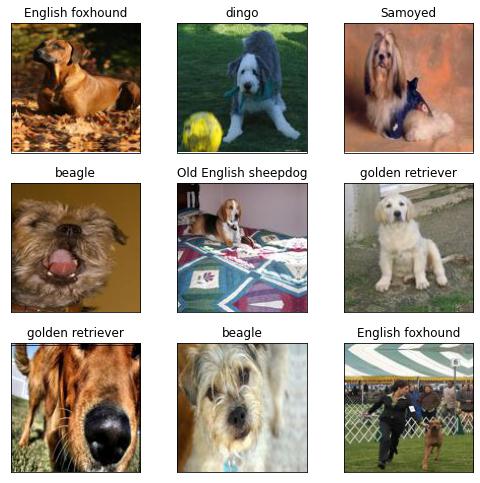

In [8]:
# Display a few training images
train_dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(train_dataiter)

show_samples(train_sample_data, train_sample_targets)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


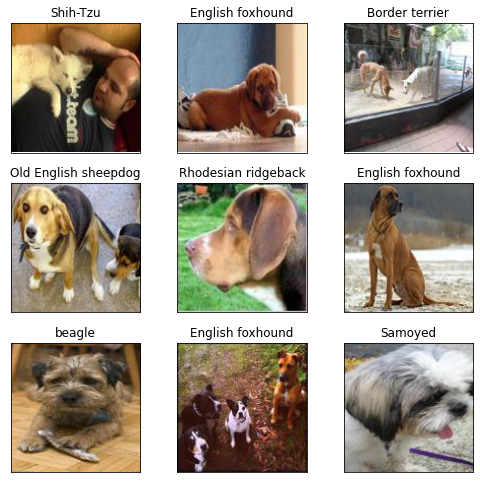

In [9]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets)

tensor shape: (750, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


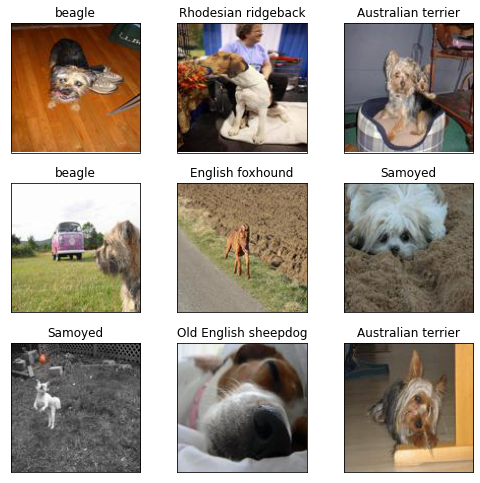

In [10]:
# Display a few calibration images
calib_dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(calib_dataiter)

show_samples(calib_sample_data, calib_sample_targets)

## Prepare Network Architecture

We use the [resnet18](https://arxiv.org/abs/1512.03385) network architecture from the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) (see [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)). However, the architecture was built for the [ImageNet dataset](https://www.image-net.org/). Thus, the architecture has an output size of 1000 which correspond to the 1000 [ImageNet](https://www.image-net.org/) classes. However, [Imagenette](https://github.com/fastai/imagenette) only has 10 classes. Thus, we need to adapt the output layer accordingly.

In [11]:
num_ftrs = arch.fc.in_features
arch.fc = nn.Linear(num_ftrs, num_classes)

print(arch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model_parameters = filter(lambda p: p.requires_grad, arch.parameters())
params = sum([np.prod(p.size()) for p in model_parameters]); 

print("Number of model parameters: {}".format(params))

Number of model parameters: 11181642


## Define Training and Test Functions

In [13]:
def train(num_epochs, model, optimizer, criterion, scheduler, max_lr, trainloader, testloader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    # Training
    for epoch in range(num_epochs):
        model, train_losses = train_one_epoch(
            epoch, model, optimizer, scheduler, criterion, trainloader, train_losses
        )
        test_losses, test_accs = test(model, criterion, testloader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs
    
def train_one_epoch(epoch_num, model, optimizer, scheduler, criterion, dataloader, losses):
    model.train()
    running_loss = 0.0
    lrs = []
    
    for batch_idx, data in enumerate(dataloader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
        # Optimizer step
        optimizer.step()
        
        # Record & update learning rate
        lrs.append(get_lr(optimizer))
        
        if scheduler is not None:
            scheduler.step()
        
        # Print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(dataloader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(dataloader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{:4}/{} ({:2.0f}%)]\tlr: {:.6f}\tLoss: {:.6f}'.format(
                epoch_num + 1, used_samples, dataset_size, train_progress, lrs[-1], avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
    
    if scheduler is not None:
        scheduler.step()
            
    return model, losses

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
     
def test(model, criterion, dataloader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(dataloader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

def test_final(model, dataloader, criterion):
    _, accs = test(model, criterion, dataloader, [], [])
    return accs[0]

## Model Training

In [14]:
%%time

# Create Model
model = arch

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

# Define Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=learning_rate)

# Define Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, learning_rate, epochs=num_epochs+1, steps_per_epoch=len(trainloader)  # we need to set "+1" here to fix a currently unknown problem with the scheduler steps
)

# Start Training
_, _, accs = train(
    num_epochs, model, optimizer, criterion, scheduler, learning_rate, trainloader, testloader
)

print()
print('Accuracies: {}'.format(accs))

Using  1  GPU(s)
Train Epoch: 1 [   0/9025 ( 0%)]	lr: 0.000240	Loss: 0.239741
Train Epoch: 1 [ 640/9025 ( 7%)]	lr: 0.000240	Loss: 2.415165
Train Epoch: 1 [1280/9025 (14%)]	lr: 0.000241	Loss: 2.400068
Train Epoch: 1 [1920/9025 (21%)]	lr: 0.000242	Loss: 2.329240
Train Epoch: 1 [2560/9025 (28%)]	lr: 0.000243	Loss: 2.277054
Train Epoch: 1 [3200/9025 (35%)]	lr: 0.000245	Loss: 2.261903
Train Epoch: 1 [3840/9025 (42%)]	lr: 0.000248	Loss: 2.206655
Train Epoch: 1 [4480/9025 (49%)]	lr: 0.000250	Loss: 2.169863
Train Epoch: 1 [5120/9025 (56%)]	lr: 0.000253	Loss: 2.121658
Train Epoch: 1 [5760/9025 (63%)]	lr: 0.000257	Loss: 2.102982
Train Epoch: 1 [6400/9025 (70%)]	lr: 0.000261	Loss: 2.053746
Train Epoch: 1 [7040/9025 (77%)]	lr: 0.000265	Loss: 2.085024
Train Epoch: 1 [7680/9025 (85%)]	lr: 0.000270	Loss: 2.022156
Train Epoch: 1 [8320/9025 (92%)]	lr: 0.000276	Loss: 2.044609
Train Epoch: 1 [8960/9025 (99%)]	lr: 0.000281	Loss: 1.959583

Test set: Avg. loss: 0.002515, Accuracy: 831/3179 (26.14%)

Train E

In [15]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Using  1  GPU(s)


In [16]:
test_acc = test_final(model, testloader, criterion); test_acc


Test set: Avg. loss: 0.001599, Accuracy: 2385/3179 (75.02%)



75.02359232463039

## Store Model and Dataloaders Pth File

We need the trained model for our OoD detection method. Thus, we store the model as pth file.

In [17]:
# Remove old pth file and create new one
!rm -f {str(model_path)+'_model.pth'}
torch.save(model.state_dict(), str(model_path)+'_model.pth')

To make sure we use the same training, test and calibration set later on we save all corresponding dataloaders.

In [18]:
# Remove old training set pth file and create new one
!rm -f {str(out_path)+'_trainset.pth'}
torch.save(trainloader, str(out_path)+'_trainset.pth') 

# Remove old test set pth file and create new one
!rm -f {str(out_path)+'_testset.pth'}
torch.save(testloader, str(out_path)+'_testset.pth')

# Remove old test set pth file and create new one
!rm -f {str(out_path)+'_calibset.pth'}
torch.save(calibloader, str(out_path)+'_calibset.pth')

In [19]:
!ls

__notebook_source__.ipynb	     imagewoof_128_resnet18_testset.pth
imagewoof_128_resnet18_calibset.pth  imagewoof_128_resnet18_trainset.pth
imagewoof_128_resnet18_model.pth


In [20]:
from IPython.display import FileLink
FileLink(r'imagewoof_128_resnet18_model.pth')

/kaggle/working/imagewoof_128_resnet18_model.pth

In [21]:
FileLink(r'imagewoof_128_resnet18_trainset.pth')

/kaggle/working/imagewoof_128_resnet18_trainset.pth

In [22]:
FileLink(r'imagewoof_128_resnet18_testset.pth')

/kaggle/working/imagewoof_128_resnet18_testset.pth

In [23]:
FileLink(r'imagewoof_128_resnet18_calibset.pth')

/kaggle/working/imagewoof_128_resnet18_calibset.pth